In [13]:
from common import helpers
from metavision_ml.preprocessing import timesurface
import numpy as np
record = helpers.load_evts_from_file(input('Raw File: '), delta_t=1e6)
height, width = record.get_size()
print('record dimensions: ', height, width)
#start_ts = 100

#delta_t = 5e6 #sampling duration
#events = record.load_delta_t(delta_t)  # load 50 milliseconds worth of events
events = next(iter(record))
events['t'] -= int(0) # important! almost all preprocessing use relative time!
volume = np.zeros((250, 2, height, width))
timesurface(events, volume, 1e6, normed=True)

record dimensions:  480 640


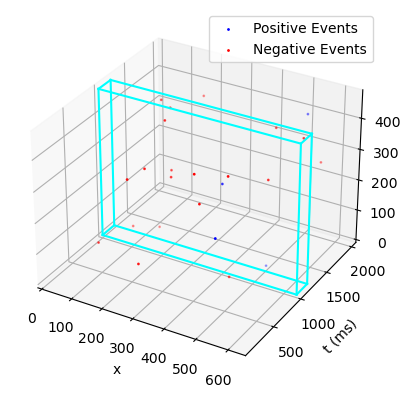

In [7]:



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



# Create meshgrid for spatial coordinates
x, z = np.meshgrid(np.arange(volume.shape[3]), np.arange(volume.shape[2]))

# Flatten the arrays for scatter plotting
x = x.flatten()
z = z.flatten()
y_p = volume[125, 1].flatten() * 2e3
y_n = volume[125, 0].flatten() * 2e3

maskp = y_p > 0
maskn = y_n > 0
x_p = x[maskp]
y_p = y_p[maskp]
z_p = z[maskp]
x_n = x[maskn]
y_n = y_n[maskn]
z_n = z[maskn]

xlim = (0, 640)
ylim = (1e3, 1.2e3)
zlim = (0, 480)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Calculate the center and size of the prism
center = [(xlim[1] + xlim[0]) / 2, (ylim[1] + ylim[0]) / 2, (zlim[1] + zlim[0]) / 2]
size = [xlim[1] - xlim[0], ylim[1] - ylim[0], zlim[1] - zlim[0]]

# Define the vertices of the prism
vertices = np.array([[center[0] - size[0]/2, center[1] - size[1]/2, center[2] - size[2]/2],
                     [center[0] + size[0]/2, center[1] - size[1]/2, center[2] - size[2]/2],
                     [center[0] + size[0]/2, center[1] + size[1]/2, center[2] - size[2]/2],
                     [center[0] - size[0]/2, center[1] + size[1]/2, center[2] - size[2]/2],
                     [center[0] - size[0]/2, center[1] - size[1]/2, center[2] + size[2]/2],
                     [center[0] + size[0]/2, center[1] - size[1]/2, center[2] + size[2]/2],
                     [center[0] + size[0]/2, center[1] + size[1]/2, center[2] + size[2]/2],
                     [center[0] - size[0]/2, center[1] + size[1]/2, center[2] + size[2]/2]])


# Define the faces of the prism
faces = [[vertices[i] for i in [0, 1, 2, 3]],
         [vertices[i] for i in [4, 5, 6, 7]], 
         [vertices[i] for i in [0, 3, 7, 4]], 
         [vertices[i] for i in [1, 2, 6, 5]], 
         [vertices[i] for i in [0, 1, 5, 4]], 
         [vertices[i] for i in [2, 3, 7, 6]]]

# Define the edges of the prism
edges = [(0, 1), (1, 2), (2, 3), (3, 0),  # Bottom edges
         (4, 5), (5, 6), (6, 7), (7, 4),  # Top edges
         (0, 4), (1, 5), (2, 6), (3, 7)]  # Side edges

# Plot each edge
for start, end in edges:
    x_edge = [vertices[start][0], vertices[end][0]]
    y_edge = [vertices[start][1], vertices[end][1]]
    z_edge = [vertices[start][2], vertices[end][2]]
    ax.plot(x_edge, y_edge, z_edge, color='cyan', zorder=9)


# Scatter plot
ax.scatter(x_p, y_p, z_p, zorder=1, s=1, color='blue', label='Positive Events')  # Example color
ax.scatter(x_n, y_n, z_n, zorder=1, s=1, color='red', label='Negative Events')
ax.set_xlabel('x')
ax.set_ylabel('t (ms)')
ax.set_zlabel('y')

ax.set_xlim([0, 640])
ax.set_zlim(0, 480)

ax.legend()


plt.show()


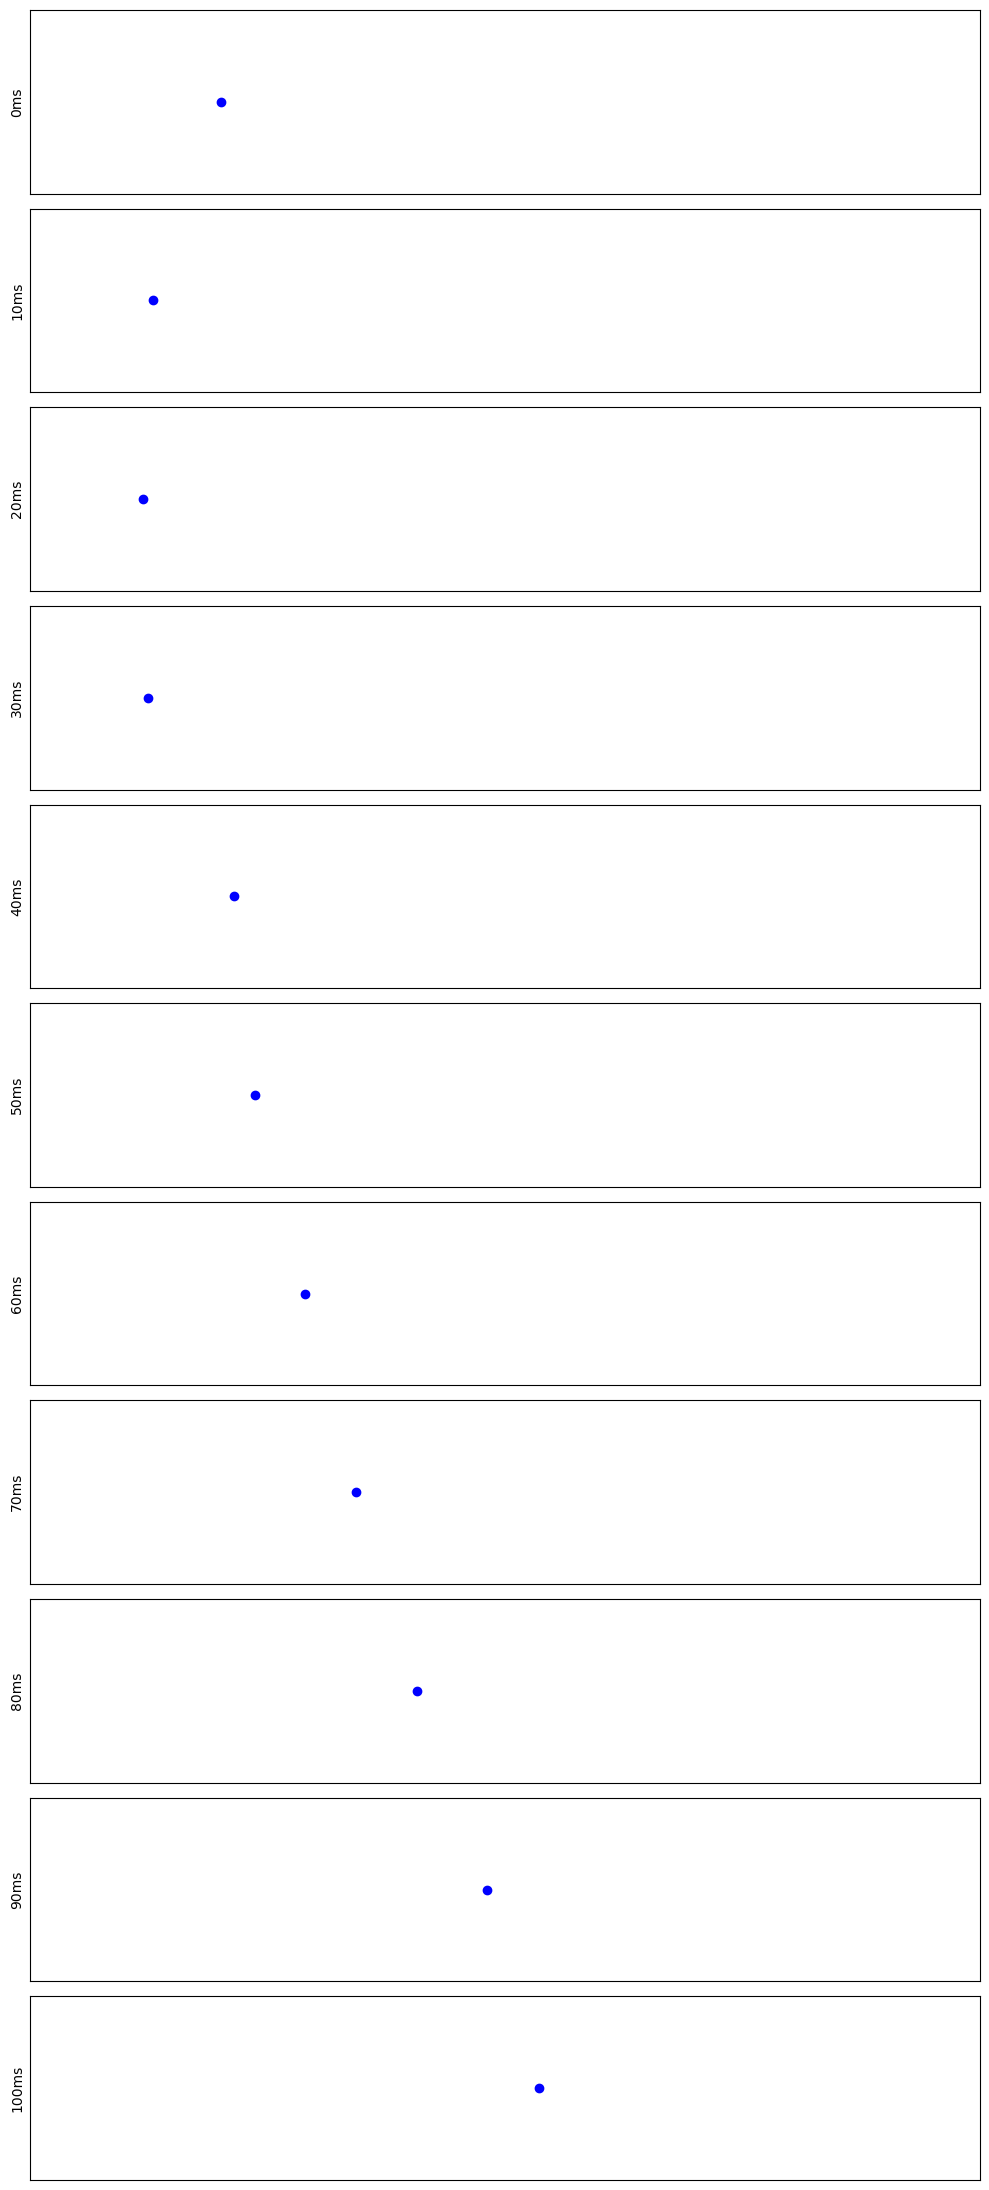

In [9]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from collections import Counter
from metavision_ml.preprocessing.viz import filter_outliers



import numpy as np

class BeadTracker:
    def __init__(self, y_bias_factor=0.3):
        self.previous_centroids = []
        self.call_count = 0
        self.y_bias_factor = y_bias_factor  # Factor to reduce y-direction movement

    def __call__(self, coords):
        self.call_count += 1

        if self.call_count <= 2 or len(self.previous_centroids) < 2:
            centroid = np.mean(coords, axis=0)
        else:
            direction = self.previous_centroids[-1] - self.previous_centroids[-2]

            # Reduce the y-component of the direction by the bias factor
            direction[1] *= self.y_bias_factor

            predicted_next_position = self.previous_centroids[-1] + direction

            # You can also apply the bias factor here if needed
            centroid = np.mean(coords, axis=0) * 0.3 + predicted_next_position * 0.5

        self.previous_centroids.append(centroid)
        return centroid

    
bead_trajectory = []
tracker = BeadTracker()
# Assuming 'time_surface' is your 3D numpy array
for time_bin in range(volume.shape[0]):
    if time_bin % 10:
        continue
    # Extract events for this time bin
    events = volume[time_bin, 0, :, :]

    # Apply your logic to extract x, y coordinates of events
    # Example: x, y = np.where(events > threshold)
    x, y = np.where(events > 0)
    # Cluster the events
    coords = np.column_stack([x, y])
    if x.size == 0 or y.size == 0:
        continue
    clustering = DBSCAN(eps=2.5, min_samples=17).fit(coords)
    labels = clustering.labels_
    cluster_counts = Counter(labels[labels != -1])
    if len(cluster_counts) == 0:
        continue
    # Find the label of the largest cluster
    # This assumes the bead is the largest cluster
    bead_cluster_label = cluster_counts.most_common(1)[0][0]

    # Calculate the centroid of the bead's cluster
    centroid = tracker(coords)

    # Store the centroid for plotting
    bead_trajectory.append(centroid)

centroid_array = np.array(bead_trajectory)
# Apply DBSCAN
clustering = DBSCAN(eps=3, min_samples=3).fit(centroid_array)

# Filter out the noise points
filtered_centroids = centroid_array[clustering.labels_ != -1]

# Filter the centroids to include only those you want to plot
valid_centroids = [point for point in centroid_array if point[0] <= 157]

# Number of subplots
num_subplots = len(valid_centroids)

# Create a figure with multiple subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(10, 2 * num_subplots))

# Check if there's only one subplot (to avoid indexing issues)
if num_subplots == 1:
    axs = [axs]

# Loop through each valid centroid and plot
for i, point in enumerate(valid_centroids):
    ax = axs[i]
    ax.scatter(point[1], 155, color='blue')  # Adjust the plotting as needed
    ax.set_xlim(150, 350)
    ax.set_ylim(160, 150)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(f'{i * 10}ms')

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_1740\1873347866.py:86: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='inferno'))


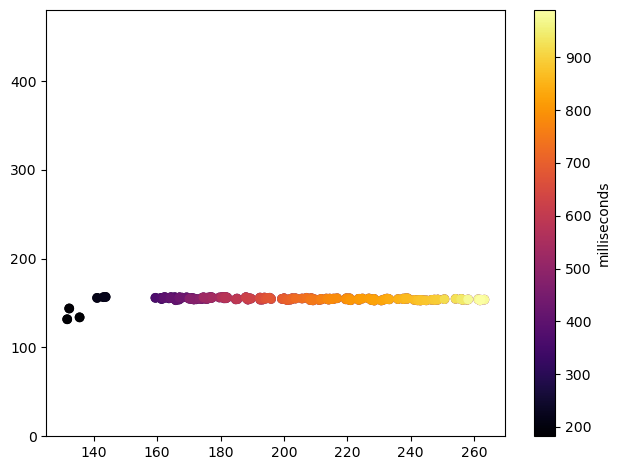

In [7]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.colors import Normalize
import matplotlib.cm as cm



import numpy as np

class BeadTracker:
    def __init__(self, y_bias_factor=0.3):
        self.previous_centroids = []
        self.call_count = 0
        self.y_bias_factor = y_bias_factor  # Factor to reduce y-direction movement

    def __call__(self, coords):
        self.call_count += 1

        if self.call_count <= 2 or len(self.previous_centroids) < 2:
            centroid = np.mean(coords, axis=0)
        else:
            direction = self.previous_centroids[-1] - self.previous_centroids[-2]

            # Reduce the y-component of the direction by the bias factor
            direction[1] *= self.y_bias_factor

            predicted_next_position = self.previous_centroids[-1] + direction

            # You can also apply the bias factor here if needed
            centroid = np.mean(coords, axis=0) * 0.3 + predicted_next_position * 0.5

        self.previous_centroids.append(centroid)
        return centroid

    
bead_trajectory = []
tracker = BeadTracker()
# Assuming 'time_surface' is your 3D numpy array
for time_bin in range(volume.shape[0]):
    events = volume[time_bin, 0, :, :]

    # Apply your logic to extract x, y coordinates of events
    # Example: x, y = np.where(events > threshold)
    x, y = np.where(events > 0)
    # Cluster the events
    coords = np.column_stack([x, y])
    if x.size == 0 or y.size == 0:
        continue
    clustering = DBSCAN(eps=2.5, min_samples=17).fit(coords)
    labels = clustering.labels_
    cluster_counts = Counter(labels[labels != -1])
    if len(cluster_counts) == 0:
        continue
    # Find the label of the largest cluster
    # This assumes the bead is the largest cluster
    bead_cluster_label = cluster_counts.most_common(1)[0][0]

    # Calculate the centroid of the bead's cluster
    centroid = tracker(coords)

    # Store the centroid for plotting
    bead_trajectory.append((*centroid, time_bin))

centroid_array = np.array(bead_trajectory)
# Apply DBSCAN
clustering = DBSCAN(eps=3, min_samples=3).fit(centroid_array)

# Filter out the noise points
filtered_centroids = centroid_array[clustering.labels_ != -1]

# Filter the centroids to include only those you want to plot
valid_centroids = [point for point in centroid_array if point[0] <= 157]
x = [point[1] for point in valid_centroids]
y = [point[0] for point in valid_centroids]
time_bins = [point[2] for point in valid_centroids]

# Normalize the time_bins to use in color mapping
norm = Normalize(vmin=min(time_bins), vmax=max(time_bins) * 2)

# Create a scatter plot
plt.scatter(x, y, c=time_bins, cmap='inferno', norm=norm)  # Adjust the plotting as needed

# Create a color bar
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='inferno'))
cbar.set_label('milliseconds')

# Create a figure with multiple subplots
plt.scatter(x, y, c=time_bins, cmap='inferno')  # Adjust the plotting as needed
plt.ylim(0, 480)
plt.tight_layout()
plt.show()


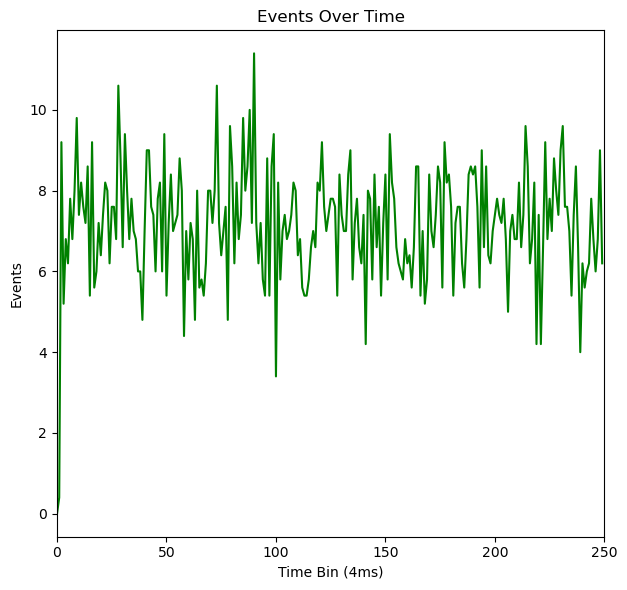

In [16]:
# Histogram
from metavision_ml.preprocessing import histo
from metavision_ml.preprocessing.viz import viz_histo
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.animation as animation

volume = np.zeros((250, 2, height, width), dtype=np.float32)
histo(events, volume, 1e6)

data = volume[:, 0]

# Aggregate data over x and y dimensions for each time slice
sum_over_time = np.sum(data, axis=(1, 2))

# Time points
time_points = np.arange(250)

# Plotting
plt.figure(figsize=(12, 6))



# Sum plot
plt.subplot(1, 2, 2)
plt.plot(time_points, sum_over_time, color='green')
plt.title('Events Over Time')
plt.xlabel('Time Bin (4ms)')
plt.ylabel('Events')
plt.xlim(0, 250)
#plt.ylim(13000, 20000)
plt.tight_layout()
plt.show()





<function matplotlib.pyplot.close(fig=None)>